In [ ]:
# for preprocessing of natural language
# important nltk requisite downloads include: tokenize, reuters
import nltk
# reuters articles corpus for training
from nltk.corpus import reuters

# nengo: see www.nengo.ai
import nengo
import nengo_spa as spa
import matplotlib.pyplot as plt
import nengo_dl

# train test split
from sklearn.model_selection import train_test_split

# numpy
import numpy as np

# other string processing
import re

In [2]:
# parameters; change as needed

# random seeding 
seed = 42
rng = np.random.RandomState(seed + 1) # 43 no reason in particular

# dimension and max similarity of semantic pointer vocabulary
# chosen using Johnson-Lindenstrauss Lemma to represent n vectors with
# (arbitrarily chosen) given max similarity angles and dimensions
rep_vocab_dim = 128 # must be divisible by 16 for spa.State to work.
rep_vocab_max_sim = 0.8

# context length: number of words looked at before
context_length = 20

# training impression
tr_impression = 0.01 # an unrealistic actual impression for time's sake
# dataset restrictions, number of articles in reuters corpus
training_restriction = 20
testing_restriction = 2

# model
model_lr = 0.005 # learning rate for PES rule.


In [3]:
# parameters; change as needed

# random seeding 
seed = 42
rng = np.random.RandomState(seed + 1) # 43 no reason in particular

# dimension and max similarity of semantic pointer vocabulary
# chosen using Johnson-Lindenstrauss Lemma to represent n vectors with
# (arbitrarily chosen) given max similarity angles and dimensions
rep_vocab_dim = 128 # must be divisible by 16 for spa.State to work.
rep_vocab_max_sim = 0.8

# context length: number of words looked at before
context_length = 20

# training impression
tr_impression = 0.01 # an unrealistic actual impression for time's sake
# dataset restrictions, number of articles in reuters corpus
training_restriction = 20
testing_restriction = 2

# model
model_lr = 0.005 # learning rate for PES rule.


In [4]:
# preprocessing functions

# vocabulary preprocessing functions to overcome limitations with
#   nengo_spa python identifier limitations
CharReplacements = {
    '!': 'CV_EXCLAMATION_MARK',
    '"': 'CV_DOUBLE_QUOTE',
    '#': 'CV_HASH',
    '$': 'CV_DOLLAR_SIGN',
    '%': 'CV_PERCENT_SIGN',
    '&': 'CV_AMPERSAND',
    "'": 'CV_SINGLE_QUOTE',
    '(': 'CV_LEFT_PARENTHESIS',
    ')': 'CV_RIGHT_PARENTHESIS',
    '*': 'CV_ASTERISK',
    '+': 'CV_PLUS',
    ',': 'CV_COMMA',
    '-': 'CV_HYPHEN',
    '.': 'CV_PERIOD',
    '/': 'CV_FORWARD_SLASH',
    ':': 'CV_COLON',
    ';': 'CV_SEMICOLON',
    '<': 'CV_LESS_THAN',
    '=': 'CV_EQUALS',
    '>': 'CV_GREATER_THAN',
    '?': 'CV_QUESTION_MARK',
    '@': 'CV_AT_SYMBOL',
    '[': 'CV_LEFT_BRACKET',
    '\\': 'CV_BACKSLASH',
    ']': 'CV_RIGHT_BRACKET',
    '^': 'CV_CARET',
    '_': 'CV_UNDERSCORE',
    '`': 'CV_GRAVE_ACCENT',
    '{': 'CV_LEFT_BRACE',
    '|': 'CV_PIPE',
    '}': 'CV_RIGHT_BRACE',
    '~': 'CV_TILDE',
}
CharReplacementsTable = str.maketrans(CharReplacements) # translation table

InvCharReplacements = {v:k for k, v in CharReplacements.items()} # inverse dict for translation

# turning "words" (tokens) to usable identifiers
def WordsToSPAVocab(w: list):
    w = [x.translate(CharReplacementsTable) for x in w] # removing special characters
    w = ["WV_" + x for x in w] # capital start for identifiers
    return w

# turning usable identifiers into "words" (tokens)
def SPAVocabToWords(w: list):
    
    # Create a function to replace all the placeholders with their corresponding characters
    def replace_placeholder_with_char(match):
        word = match.group(0)
        return InvCharReplacements.get(word, word)  # Return the original if no replacement exists

    # Regular expression to match all the placeholder words (e.g., "EXCLAMATION_MARK")
    pattern = r'\b(?:' + '|'.join(map(re.escape, InvCharReplacements.keys())) + r')\b'

    # inverse operations for WordsToSPAVocab
    w = [x[3:] for x in w]
    w = [re.sub(pattern, replace_placeholder_with_char, x) for x in w] # removing special characters
    return w 

In [5]:
# pre-processing

# distinguishing training and testing data
reuters_training_ids = [x for x in reuters.fileids() if "training/" in x]
reuters_testing_ids = [x for x in reuters.fileids() if "test/" in x]

# restriction of training set for time's sake
reuters_training_ids = reuters_training_ids[:training_restriction]
reuters_testing_ids = reuters_testing_ids[:testing_restriction]

# train and validation

# training set vocabulary
vocab = [
    t
    for x in reuters_training_ids
    for t in reuters.words(x)
] # all words in training
# print(len(vocab))
vocab = list(set(vocab)) # unique words
vocab += ['PRE_PAD'] # padding character
vocab += ['W_UNK'] # unknown placeholder
# print(len(vocab))

spa_vocab = WordsToSPAVocab(vocab)

# training set generation
training_set = [
    [reuters.words(x)[max(0,i-context_length):max(0,i)], [reuters.words(x)[i]]]
    for x in reuters_training_ids
    for i in range(len(reuters.words(x)))
]
# padding for training set
training_set = [
    [['PRE_PAD'] * (context_length - len(x[0])) + x[0], x[1]]
    for x in training_set
]

# testing set generation
testing_set = [
    [reuters.words(x)[max(0,i-context_length):max(0,i)], [reuters.words(x)[i]]]
    for x in reuters_testing_ids
    for i in range(len(reuters.words(x)))
]
# padding for training set
testing_set = [
    [['PRE_PAD'] * (context_length - len(x[0])) + x[0], x[1]]
    for x in testing_set
]

In [ ]:
# attempt at adding a basic word embedding in here

# finding suitable vector relationships between the words

# converting to form that can populate model vocabulary

# redimension of model vocabulary parameter

In [ ]:
# semantic pointer vocabulary generation for model

# initial generation

# vocabulary for our model: store of semantic pointers 
model_vocab = spa.Vocabulary(dimensions=rep_vocab_dim, strict=False, pointer_gen=rng, max_similarity=rep_vocab_max_sim)
# initial creation is random
model_vocab.populate(";".join(spa_vocab))

# candidate inital creations
# model_vocab.populate(".normalized();".join(spa_vocab))
# model_vocab.populate(".unitary();".join(spa_vocab))

# input
# custom input
# s1 = "This is a sentence."
# nltk.word_tokenize(s1)

In [7]:
# input 

# model input functions
# will return a context vector of tokens dependent on time
def context_in(t):
	if t <= training_time:
		impression = tr_impression # how long the model sees each word for (impression time)
		pair = training_set[int(t // impression)]
		left = WordsToSPAVocab(pair[0])
		return " + ".join(left) # returns training context
	else:
		t_test = t - training_time
		impression = tr_impression # how long the model sees each word for (impression time)
		pair = testing_set[int(t_test // impression)]
		left = WordsToSPAVocab(["W_UNK" if x not in vocab else x for x in pair[0]])
		return " + ".join(left) # returns training context
	

# will return the desired predicted token dependent on time
def find_target(t):
	if t <= training_time:
		impression = tr_impression # how long the model sees each word for (impression time)
		pair = training_set[int(t // impression)]
		return WordsToSPAVocab(pair[1])[0] # should find targets in parallel to context
	else:
		t_test = t - training_time
		impression = tr_impression # how long the model sees each word for (impression time)
		pair = testing_set[int(t_test // impression)]
		return WordsToSPAVocab("W_UNK" if x not in vocab else x for x in pair[1])[0] # should find targets in parallel to context

# training time length
training_time = len(training_set)*tr_impression
# testing time length
testing_time = (len(testing_set)-1)*tr_impression

def is_recall(t):
	return t > training_time

In [8]:
# model
with spa.Network(seed=seed) as model:
    # transcoding training into semantic pointers
    context = spa.Transcode(context_in, output_vocab=model_vocab)
    target = spa.Transcode(find_target, output_vocab=model_vocab)

    # State (ensembles) for learning
    pre_state = spa.State(
        model_vocab, subdimensions=model_vocab.dimensions, represent_cc_identity=False
    )
    post_state = spa.State(
        model_vocab, subdimensions=model_vocab.dimensions, represent_cc_identity=False
    )
    error = spa.State(model_vocab)

    # signal connections between objects see report for connection logic
    # input and error
    context >> pre_state
    -post_state >> error
    target >> error

    # learning between ensembles
    assert len(pre_state.all_ensembles) == 1
    assert len(post_state.all_ensembles) == 1
    learning_connection = nengo.Connection(
        pre_state.all_ensembles[0],
        post_state.all_ensembles[0],
        function=lambda x: np.random.random(model_vocab.dimensions),
        learning_rule_type=nengo.PES(model_lr), # Prescribed Error Sensitivity
    )
    nengo.Connection(error.output, learning_connection.learning_rule, transform=-1)

    # Suppress learning in the final iteration to test
    is_recall_node = nengo.Node(is_recall, size_out=1)
    for ens in error.all_ensembles:
        nengo.Connection(
            is_recall_node, ens.neurons, transform=-100 * np.ones((ens.n_neurons, 1))
        )

    # Probes to record simulation data
    p_target = nengo.Probe(target.output)
    p_error = nengo.Probe(error.output, synapse=0.01)
    p_post_state = nengo.Probe(post_state.output, synapse=0.01)
    # sampling more consistently for word data
    p_target_word = nengo.Probe(target.output, sample_every=tr_impression/2)
    p_result_word = nengo.Probe(post_state.output, synapse=0.01, sample_every=tr_impression/2)
    


In [ ]:
# preliminary simulation
simulation_length = training_time + testing_time

with nengo_dl.Simulator(model) as sim:
    sim.run(simulation_length)

|                     Building network (0%)                    | ETA:  --:--:--
|####                  Building network (6%)                     | ETA: 0:00:00
|####                  Building network (6%)                     | ETA: 0:00:01
|####                  Building network (6%)                     | ETA: 0:00:02
|####                  Building network (6%)                     | ETA: 0:00:03
|####                  Building network (6%)                     | ETA: 0:00:04
|#######              Building network (12%)                     | ETA: 0:00:08
|#######              Building network (12%)                     | ETA: 0:00:08
|#######              Building network (12%)                     | ETA: 0:00:09
|#######              Building network (12%)                     | ETA: 0:00:09
|#######              Building network (12%)                     | ETA: 0:00:10
|#######              Building network (12%)                     | ETA: 0:00:10
|#######              Building network (

Amount of simulated training time: 28.75
Amount of simulated testing time: 10.290000000000001


Text(0.5, 0, 'Time (Testing Starts After: 28.75)')

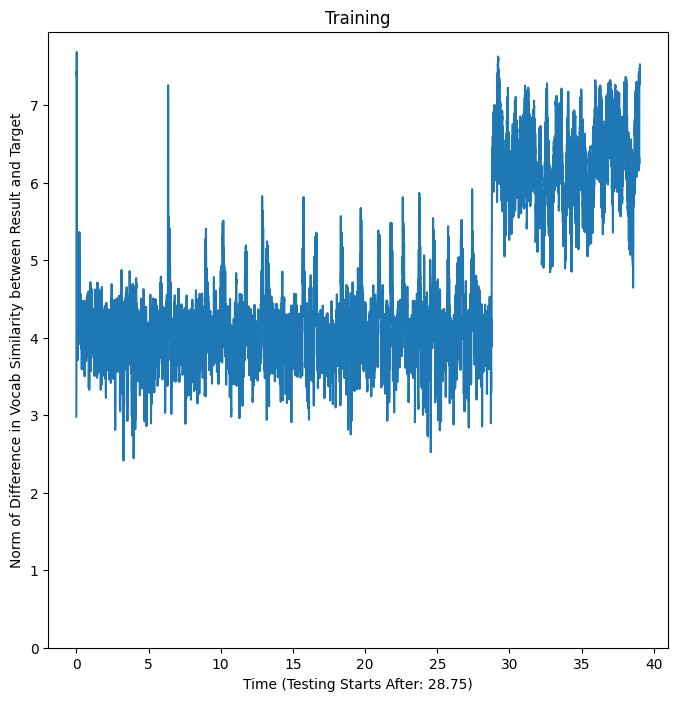

In [13]:
print(f"Amount of simulated training time: {training_time}")
print(f"Amount of simulated testing time: {testing_time}")

# plotting metrics for training
# plt.figure()
# plt.plot(sim.trange(), np.linalg.norm(sim.data[p_error], axis=1))
# plt.xlim(0, simulation_length)
# plt.ylim(bottom=0)
# plt.title("Error signal")
# plt.xlabel("Time [s]")
# plt.ylabel("Error norm")

# plotting metrics for testing
plt.figure(figsize=(8,8))
plt.plot(sim.trange(), np.linalg.norm(spa.similarity(sim.data[p_post_state], model_vocab) - spa.similarity(sim.data[p_target], model_vocab), axis = 1))
plt.ylim(bottom=0)
plt.title("Training")
plt.ylabel("Norm of Difference in Vocab Similarity between Result and Target")
plt.xlabel(f"Time (Testing Starts After: {training_time})")


In [44]:
print(" ".join(SPAVocabToWords(["WV_" + spa.text(sim.data[p_result_word][i], vocab=model_vocab, maximum_count=1).split("WV_",1)[-1] 
 for i in range(len(training_set), len(training_set)+100)])[::2]))
print(" ".join(SPAVocabToWords(["WV_" + spa.text(sim.data[p_target_word][i], vocab=model_vocab, maximum_count=1).split("WV_",1)[-1] 
 for i in range(len(training_set), len(training_set)+100)])[::2]))


have yet had had reply . We this this as as on how how open open market market is is CV_COMMACV_DOUBLE_QUOTE Thatcher Thatcher Thatcher told told told SUGAR shortly shortly We We We shall more powers than have now now , when when additional example open powers under Financial Financial
reply . We We see this as test on how open open the Japanese market is CV_COMMACV_DOUBLE_QUOTE Thatcher said said . Thatcher told Parliament " shortly CV_PERIODCV_PERIODCV_PERIOD We We shall have more than we have now now , when , example the powers under under the Financial Services Act the
